Total records in sfrs (before filtering by image/spectrum): 4851200
Total records after filtering by image/spectrum availability: 151190
Total records after removing NaN in AVG: 34613
Total records after filtering AVG >= -80: 30752
Among them, FLAG == 0: 16841
Among them, FLAG != 0: 13911


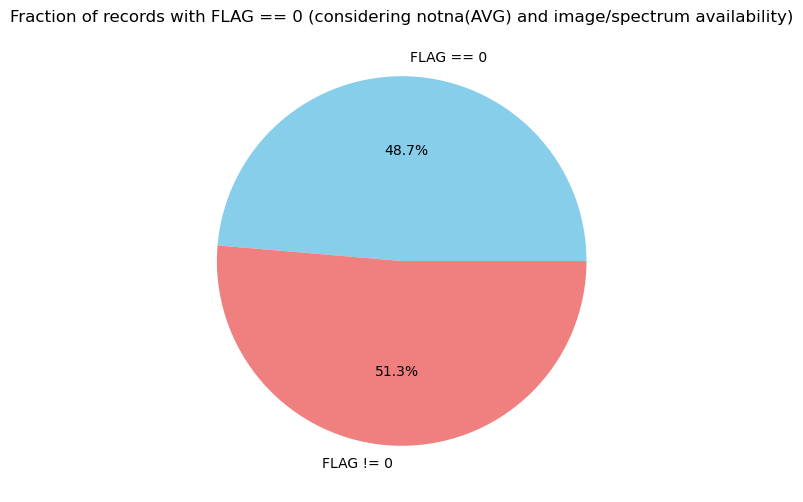

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
print("Total records in sfrs (before filtering by image/spectrum):", len(sfrs))

with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
print("Total records after filtering by image/spectrum availability:", len(sfrs))

sfrs = sfrs[sfrs["AVG"].notna()].copy()
print("Total records after removing NaN in AVG:", len(sfrs))

sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
print("Total records after filtering AVG >= -80:", len(sfrs_filtered))

sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()
sfrs_flag_not0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] != 0.0].copy()
print("Among them, FLAG == 0:", len(sfrs_flag0_filtered))
print("Among them, FLAG != 0:", len(sfrs_flag_not0_filtered))

sfrs_flag0 = sfrs[sfrs["FLAG"] == 0.0]
labels_pie = ["FLAG == 0", "FLAG != 0"]
sizes = [len(sfrs_flag0), len(sfrs) - len(sfrs_flag0)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=["skyblue", "lightcoral"])
plt.title("Fraction of records with FLAG == 0 (considering notna(AVG) and image/spectrum availability)")
plt.show()

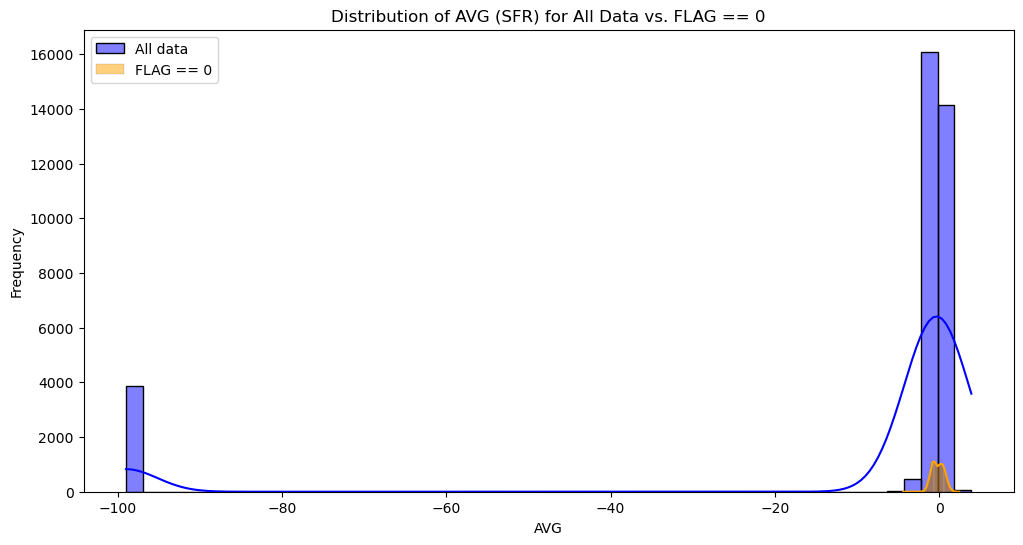

In [2]:
plt.figure(figsize=(12,6))
sns.histplot(sfrs["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

After filtering AVG>=-80: total 30752, among them FLAG==0: 16841


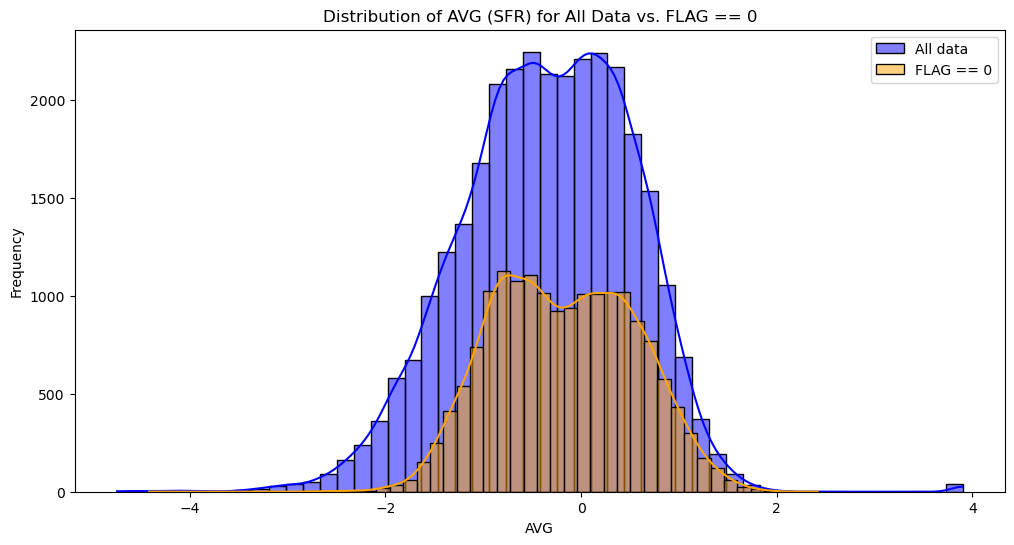

In [3]:
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print(f"After filtering AVG>=-80: total {len(sfrs_filtered)}, among them FLAG==0: {len(sfrs_flag0_filtered)}")

plt.figure(figsize=(12,6))
sns.histplot(sfrs_filtered["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0_filtered["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

Spectra_all_list[0] shape: (30752, 4620)
Spectra_flag0_list[0] shape: (16841, 4620)
Spectra_flag_not0_list[0] shape: (13911, 4620)


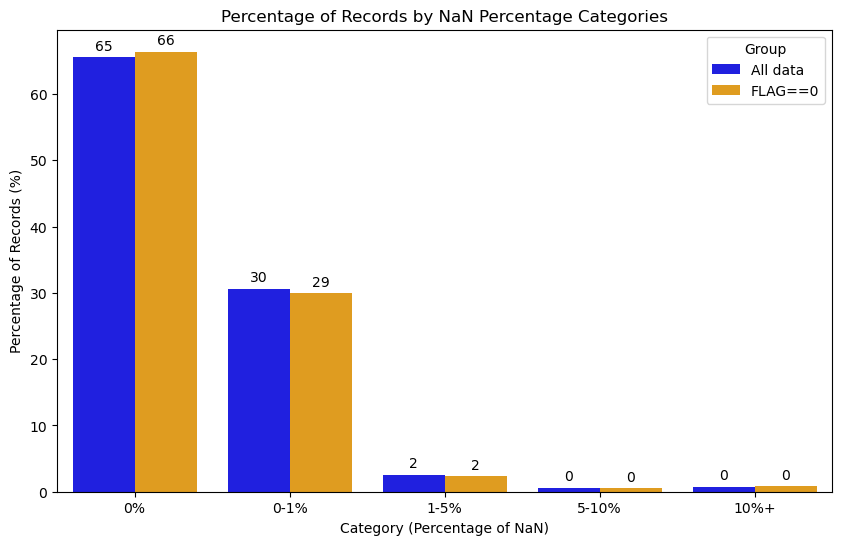

In [4]:
mask_all = np.in1d(metadata_indices, sfrs_filtered.index)            
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)      
mask_flag_not0 = np.in1d(metadata_indices, sfrs_flag_not0_filtered.index) 

spectra_all_list = []
spectra_flag0_list = []
spectra_flag_not0_list = [] 

for zoom in range(4):
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        spec_data = cube[spec_key][:] 
    spectra_all_list.append(spec_data[mask_all])
    spectra_flag0_list.append(spec_data[mask_flag0])
    spectra_flag_not0_list.append(spec_data[mask_flag_not0])

print("Spectra_all_list[0] shape:", spectra_all_list[0].shape)
print("Spectra_flag0_list[0] shape:", spectra_flag0_list[0].shape)
print("Spectra_flag_not0_list[0] shape:", spectra_flag_not0_list[0].shape)

nan_counts_all = np.sum(np.isnan(spectra_all_list[0]), axis=1)
nan_counts_flag0 = np.sum(np.isnan(spectra_flag0_list[0]), axis=1)
total_length = spectra_all_list[0].shape[1]

def categorize_nan_percentage(nan_counts, total_length):
    """
    Converts the absolute number of NaNs into a percentage of the spectrum length
    and returns string categories:
      - "0%" if 0% NaNs,
      - "0-1%" if up to 1%,
      - "1-5%" if up to 5%,
      - "5-10%" if up to 10%,
      - "10%+" if more than 10%.
    """
    percentages = (nan_counts / total_length) * 100
    categories = []
    for p in percentages:
        if p == 0:
            categories.append("0%")
        elif p <= 1:
            categories.append("0-1%")
        elif p <= 5:
            categories.append("1-5%")
        elif p <= 10:
            categories.append("5-10%")
        else:
            categories.append("10%+")
    return categories

categories_all = categorize_nan_percentage(nan_counts_all, total_length)
categories_flag0 = categorize_nan_percentage(nan_counts_flag0, total_length)

df_all = pd.DataFrame({"NaN_Category": categories_all, "Group": "All data"})
df_flag0 = pd.DataFrame({"NaN_Category": categories_flag0, "Group": "FLAG==0"})
df = pd.concat([df_all, df_flag0], ignore_index=True)

category_order = ["0%", "0-1%", "1-5%", "5-10%", "10%+"]

grouped = df.groupby(["Group", "NaN_Category"]).size().reset_index(name="count")
total_counts = df.groupby("Group").size().reset_index(name="total")
merged = pd.merge(grouped, total_counts, on="Group")
merged["percent"] = merged["count"] / merged["total"] * 100

merged["NaN_Category"] = pd.Categorical(merged["NaN_Category"], categories=category_order, ordered=True)
merged = merged.sort_values(["Group", "NaN_Category"])

plt.figure(figsize=(10,6))
ax = sns.barplot(data=merged, x="NaN_Category", y="percent", hue="Group", 
                 order=category_order, palette=["blue", "orange"])
plt.title("Percentage of Records by NaN Percentage Categories")
plt.xlabel("Category (Percentage of NaN)")
plt.ylabel("Percentage of Records (%)")

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

Zoom level 0 (FLAG==0): found 12207 NaN blocks, average length = 34.69, max = 4620
Zoom level 0 (FLAG!=0): found 11869 NaN blocks, average length = 29.19, max = 4620
Zoom level 1 (FLAG==0): found 12045 NaN blocks, average length = 18.11, max = 2310
Zoom level 1 (FLAG!=0): found 11748 NaN blocks, average length = 15.26, max = 2310
Zoom level 2 (FLAG==0): found 11954 NaN blocks, average length = 9.68, max = 1155
Zoom level 2 (FLAG!=0): found 11667 NaN blocks, average length = 8.23, max = 1155
Zoom level 3 (FLAG==0): found 11875 NaN blocks, average length = 5.46, max = 577
Zoom level 3 (FLAG!=0): found 11573 NaN blocks, average length = 4.76, max = 577


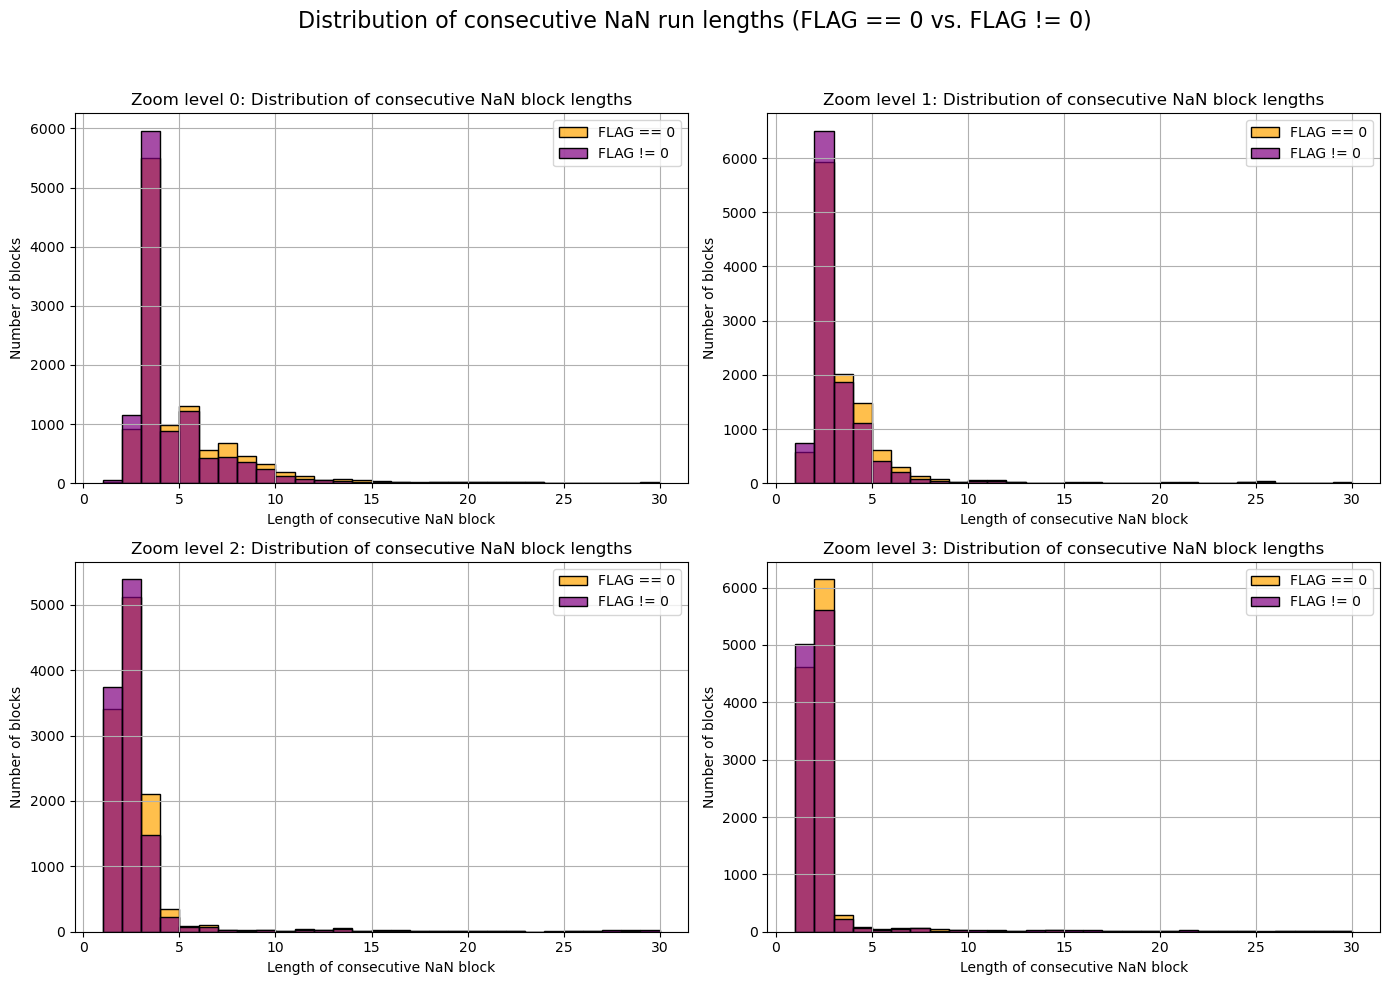

In [5]:
def get_run_lengths(bool_arr):
    diff = np.diff(np.concatenate(([0], bool_arr.astype(int), [0])))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return ends - starts

run_lengths_flag0_by_zoom = []
run_lengths_flag_not0_by_zoom = []

for zoom in range(4):
    runs_flag0 = []
    runs_flag_not0 = []
    
    for row in spectra_flag0_list[zoom]:
        run_lengths = get_run_lengths(np.isnan(row))
        if run_lengths.size > 0:
            runs_flag0.extend(run_lengths)
    run_lengths_flag0_by_zoom.append(np.array(runs_flag0))
    
    for row in spectra_flag_not0_list[zoom]:
        run_lengths = get_run_lengths(np.isnan(row))
        if run_lengths.size > 0:
            runs_flag_not0.extend(run_lengths)
    run_lengths_flag_not0_by_zoom.append(np.array(runs_flag_not0))
    
    print(
        f"Zoom level {zoom} (FLAG==0): found {len(runs_flag0)} NaN blocks, "
        f"average length = {np.mean(runs_flag0) if len(runs_flag0)>0 else 0:.2f}, "
        f"max = {np.max(runs_flag0) if len(runs_flag0)>0 else 0}"
    )
    print(
        f"Zoom level {zoom} (FLAG!=0): found {len(runs_flag_not0)} NaN blocks, "
        f"average length = {np.mean(runs_flag_not0) if len(runs_flag_not0)>0 else 0:.2f}, "
        f"max = {np.max(runs_flag_not0) if len(runs_flag_not0)>0 else 0}"
    )

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
bins = np.arange(1, 31)  

for i in range(4):
    ax = axes[i]
    sns.histplot(
        run_lengths_flag0_by_zoom[i],
        bins=bins,
        color="orange",
        label="FLAG == 0",
        kde=False,
        stat="count",
        alpha=0.7,
        ax=ax
    )
    sns.histplot(
        run_lengths_flag_not0_by_zoom[i],
        bins=bins,
        color="purple",
        label="FLAG != 0",
        kde=False,
        stat="count",
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"Zoom level {i}: Distribution of consecutive NaN block lengths")
    ax.set_xlabel("Length of consecutive NaN block")
    ax.set_ylabel("Number of blocks")
    ax.legend()
    ax.grid(True)

plt.suptitle("Distribution of consecutive NaN run lengths (FLAG == 0 vs. FLAG != 0)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

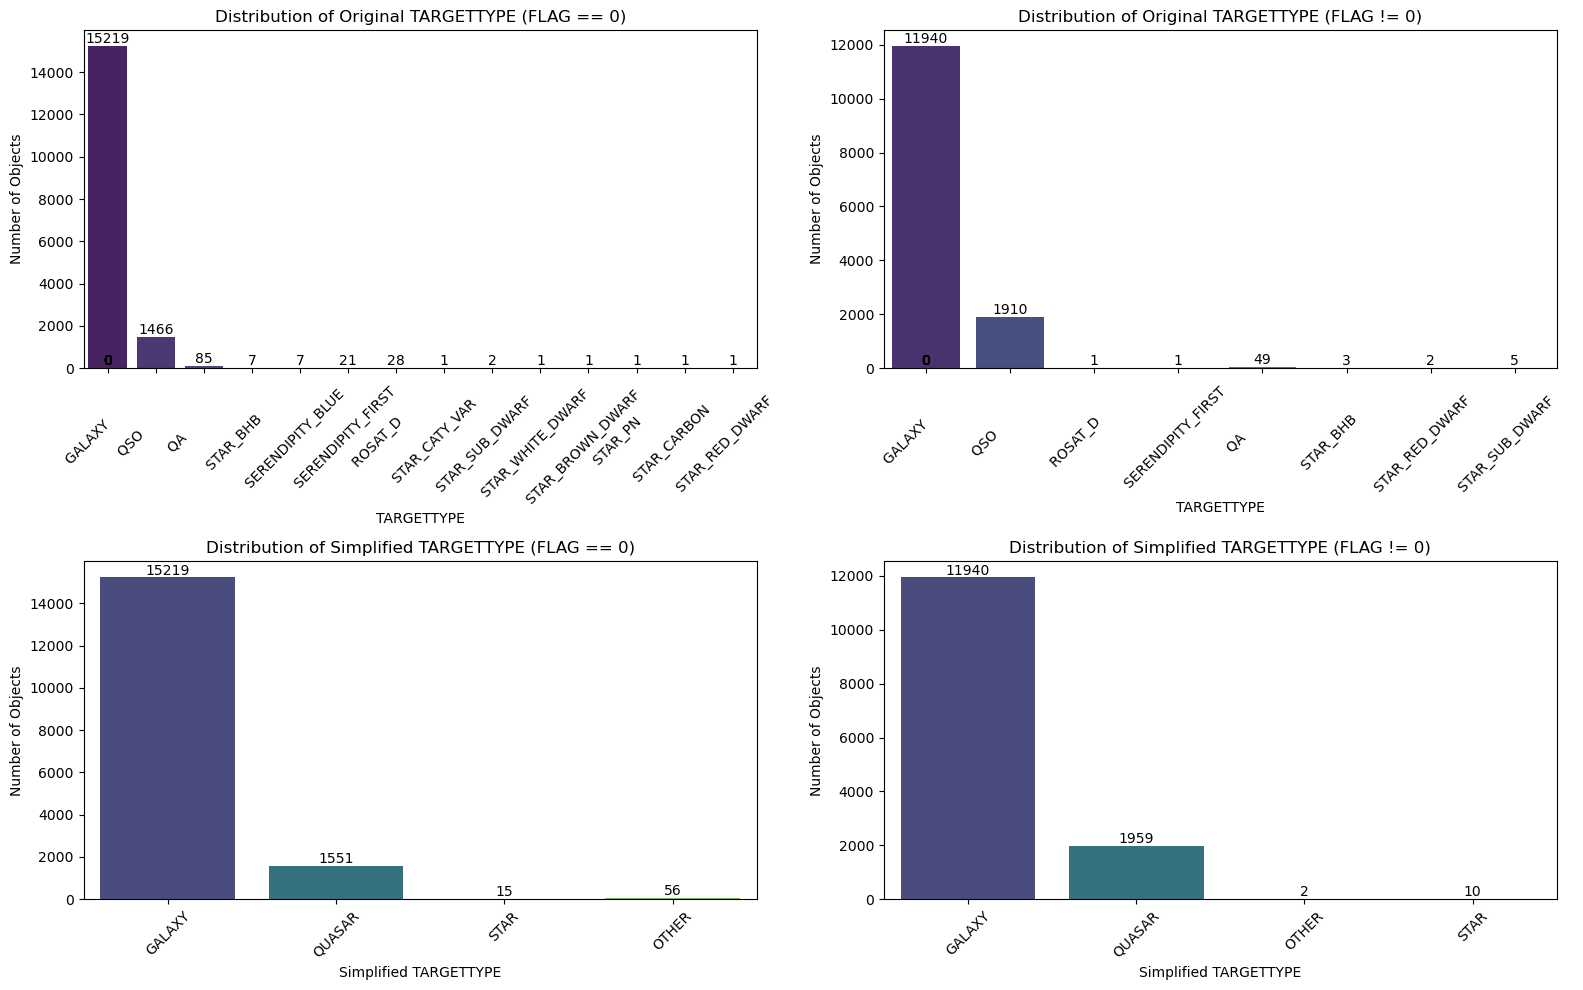

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels_flag0 = sfrs_flag0_filtered.loc[:, "TARGETTYPE"]
labels_flag_not0 = sfrs_filtered.loc[sfrs_filtered["FLAG"] != 0.0, "TARGETTYPE"]

def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

df_flag0_orig = pd.DataFrame({"TARGETTYPE": labels_flag0})
df_flag_not0_orig = pd.DataFrame({"TARGETTYPE": labels_flag_not0})

df_flag0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag0).apply(simplify_targettype)})
df_flag_not0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag_not0).apply(simplify_targettype)})

plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data=df_flag0_orig, x="TARGETTYPE", hue="TARGETTYPE", dodge=False, palette="viridis", ax=ax1)
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
ax1.set_title("Distribution of Original TARGETTYPE (FLAG == 0)")
ax1.set_xlabel("TARGETTYPE")
ax1.set_ylabel("Number of Objects")
ax1.tick_params(axis='x', labelrotation=45)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(data=df_flag_not0_orig, x="TARGETTYPE", hue="TARGETTYPE", dodge=False, palette="viridis", ax=ax2)
if ax2.get_legend() is not None:
    ax2.get_legend().remove()
ax2.set_title("Distribution of Original TARGETTYPE (FLAG != 0)")
ax2.set_xlabel("TARGETTYPE")
ax2.set_ylabel("Number of Objects")
ax2.tick_params(axis='x', labelrotation=45)

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data=df_flag0_simpl, x="Simplified_TARGETTYPE", hue="Simplified_TARGETTYPE", dodge=False, palette="viridis", ax=ax3)
if ax3.get_legend() is not None:
    ax3.get_legend().remove()
ax3.set_title("Distribution of Simplified TARGETTYPE (FLAG == 0)")
ax3.set_xlabel("Simplified TARGETTYPE")
ax3.set_ylabel("Number of Objects")
ax3.tick_params(axis='x', labelrotation=45)

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=df_flag_not0_simpl, x="Simplified_TARGETTYPE", hue="Simplified_TARGETTYPE", dodge=False, palette="viridis", ax=ax4)
if ax4.get_legend() is not None:
    ax4.get_legend().remove()
ax4.set_title("Distribution of Simplified TARGETTYPE (FLAG != 0)")
ax4.set_xlabel("Simplified TARGETTYPE")
ax4.set_ylabel("Number of Objects")
ax4.tick_params(axis='x', labelrotation=45)

for ax in [ax1, ax2, ax3, ax4]:
    for patch in ax.patches:
        ax.annotate(
            format(int(patch.get_height()), 'd'),
            (patch.get_x() + patch.get_width() / 2., patch.get_height()),
            ha='center', va='center', xytext=(0, 5), textcoords='offset points'
        )

plt.tight_layout()
plt.show()